1. Importing Libraries

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

2. Loading and Preprocessing Data

 Resizing Images

In [3]:
import PIL.Image as Image

def resize_images(path):
  for img_file in os.listdir(path):
    img = Image.open(os.path.join(path, img_file))
    img = img.resize((224,224))
    img.save(os.path.join(path, img_file))

if __name__ == "__main__":
  directories = ["/content/drive/MyDrive/dental/average","/content/drive/MyDrive/dental/horizontal","/content/drive/MyDrive/dental/vertical"]
  for directory in directories:
    resize_images(directory)

In [4]:
# Paths to directories
data_dir = '/content/drive/MyDrive/dental/'
categories = ['average', 'horizontal', 'vertical']
img_size = 128

# Load and preprocess data
def load_data(data_dir, categories, img_size):
    data = []
    labels = []
    for idx, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(idx)
    data = np.array(data, dtype='float32') / 224.0
    labels = np.array(labels)
    return data, labels

data, labels = load_data(data_dir, categories, img_size)
train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state=42)

In [5]:
# Number of images in the train dataset
num_train_images = train_X.shape[0]
print("Number of images in the train dataset:", num_train_images)

# Number of images in the test dataset
num_test_images = test_X.shape[0]
print("Number of images in the test dataset:", num_test_images)

Number of images in the train dataset: 159
Number of images in the test dataset: 40


In [6]:
# Number of images per class in the train dataset
train_images_per_class = {category: np.sum(train_y == idx) for idx, category in enumerate(categories)}
print("Number of images per class in the train dataset:")
print(train_images_per_class)

# Number of images per class in the test dataset
test_images_per_class = {category: np.sum(test_y == idx) for idx, category in enumerate(categories)}
print("\nNumber of images per class in the test dataset:")
print(test_images_per_class)

Number of images per class in the train dataset:
{'average': 53, 'horizontal': 45, 'vertical': 61}

Number of images per class in the test dataset:
{'average': 7, 'horizontal': 17, 'vertical': 16}


3. Data Visualization

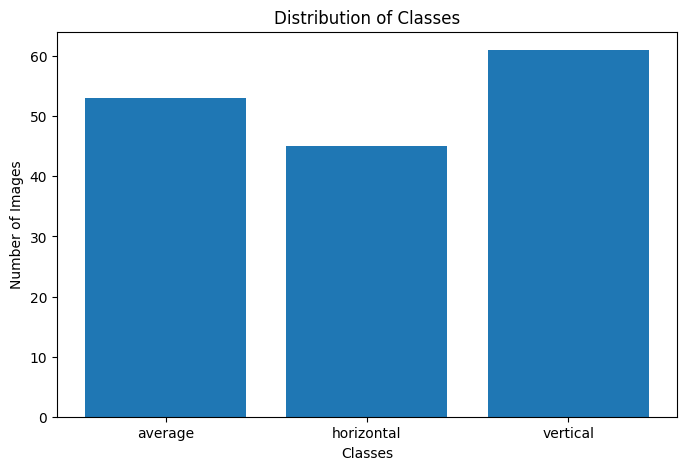

In [7]:
# Plotting distribution of classes
plt.figure(figsize=(8, 5))
plt.bar(categories, [np.sum(train_y == i) for i in range(len(categories))])
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

Average

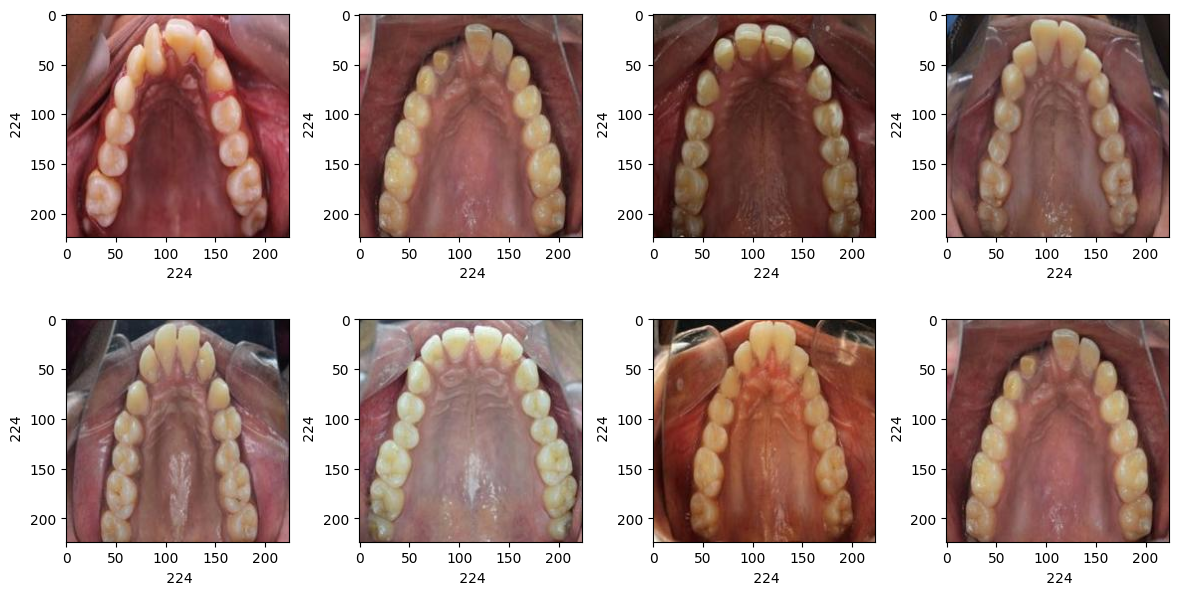

In [8]:
import os
import random
from matplotlib import pyplot as plt
from matplotlib.image import imread

plt.figure(figsize=(12, 12))
path = "/content/drive/MyDrive/dental/average"
for i in range(1, 9):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(os.path.join(path, random.choice(sorted(os.listdir(path)))))
    plt.imshow(rand_img)
    plt.xlabel(f" {rand_img.shape[1]}", fontsize=10)
    plt.ylabel(f" {rand_img.shape[0]}", fontsize=10)

plt.show()


Vertical

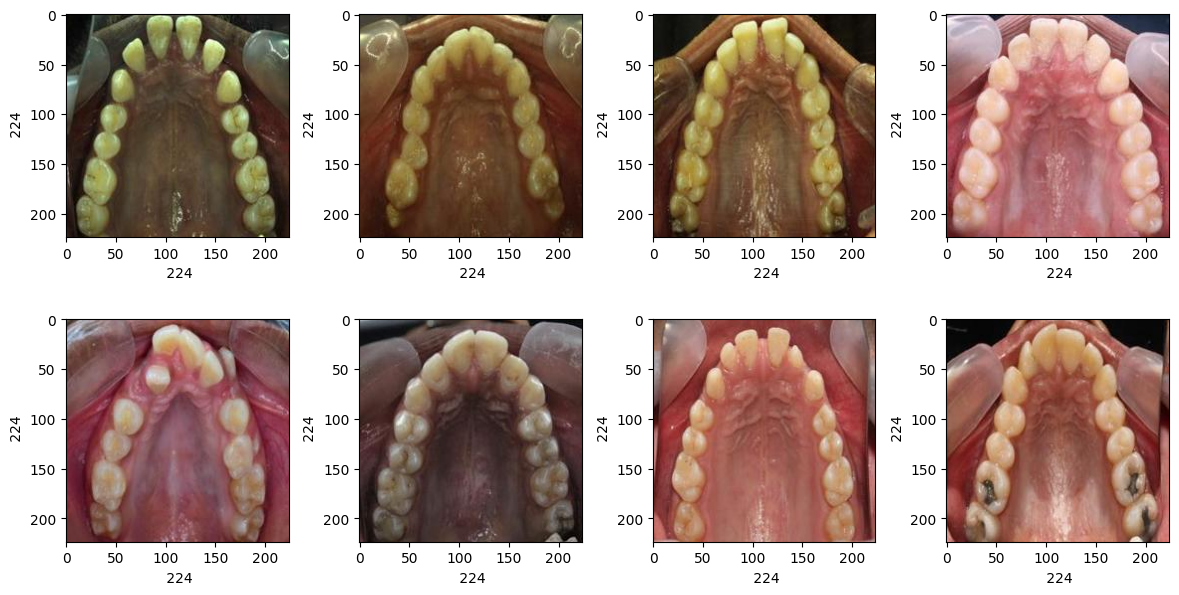

In [9]:
import os
import random
from matplotlib import pyplot as plt
from matplotlib.image import imread

plt.figure(figsize=(12, 12))
path = "/content/drive/MyDrive/dental/vertical"
for i in range(1, 9):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(os.path.join(path, random.choice(sorted(os.listdir(path)))))
    plt.imshow(rand_img)
    plt.xlabel(f" {rand_img.shape[1]}", fontsize=10)
    plt.ylabel(f" {rand_img.shape[0]}", fontsize=10)

plt.show()


Horizontal

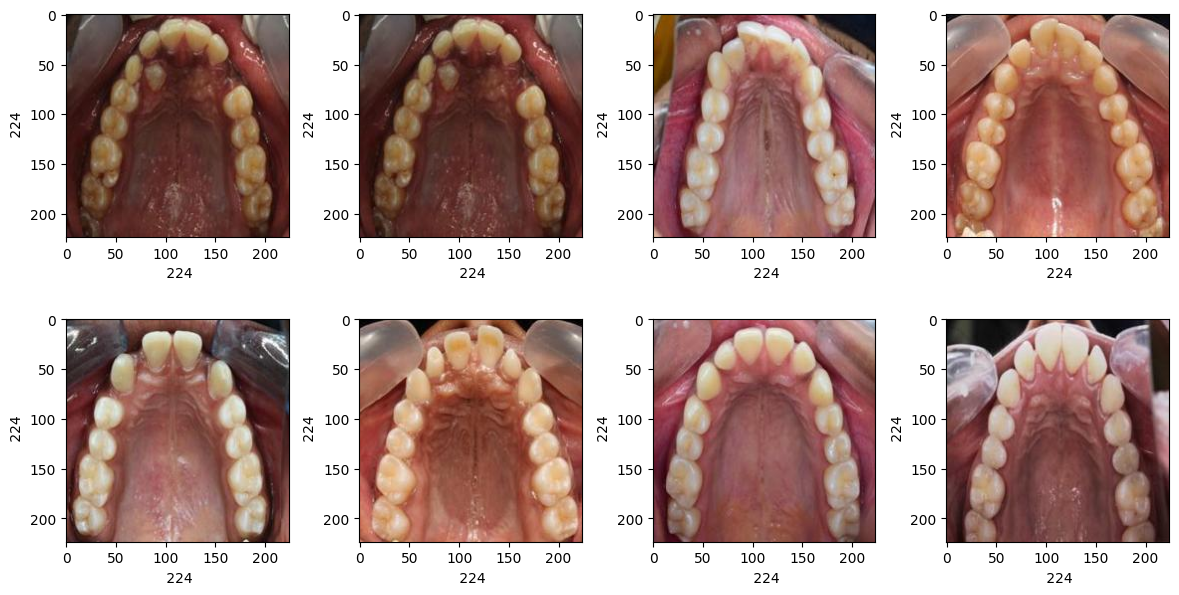

In [10]:
import os
import random
from matplotlib import pyplot as plt
from matplotlib.image import imread

plt.figure(figsize=(12, 12))
path = "/content/drive/MyDrive/dental/horizontal"
for i in range(1, 9):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(os.path.join(path, random.choice(sorted(os.listdir(path)))))
    plt.imshow(rand_img)
    plt.xlabel(f" {rand_img.shape[1]}", fontsize=10)
    plt.ylabel(f" {rand_img.shape[0]}", fontsize=10)

plt.show()


4. Data Augmentation

In [11]:
# Create data augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

5. Define VGG16 Model as Base

In [12]:
# Define VGG16 model as base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


6. Model Architecture

In [13]:
# Model architecture
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

7. Compile, Train, and Evaluate the Model

In [14]:
from tensorflow.keras.models import save_model
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6)

# Train the model with augmentation
history = model.fit(
    train_datagen.flow(train_X, train_y, batch_size=32),
    epochs=50,
    validation_data=(test_X, test_y),
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        lr_scheduler
    ]
)

evaluation = model.evaluate(test_X, test_y)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

# Save the trained model
save_model(model, '/content/drive/MyDrive/dental/model.h5')

Epoch 1/50
5/5 [==============================] - 15s 1s/step - loss: 1.2764 - accuracy: 0.3396 - val_loss: 1.1705 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 2/50
5/5 [==============================] - 1s 178ms/step - loss: 1.1891 - accuracy: 0.3774 - val_loss: 1.1273 - val_accuracy: 0.4250 - lr: 1.0000e-04
Epoch 3/50
5/5 [==============================] - 1s 157ms/step - loss: 1.2941 - accuracy: 0.3459 - val_loss: 1.0706 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 4/50
5/5 [==============================] - 1s 151ms/step - loss: 1.2587 - accuracy: 0.3459 - val_loss: 1.0768 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 5/50
5/5 [==============================] - 1s 154ms/step - loss: 1.1496 - accuracy: 0.3711 - val_loss: 1.0956 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 6/50
5/5 [==============================] - 1s 239ms/step - loss: 1.1227 - accuracy: 0.3962 - val_loss: 1.0927 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 7/50
5/5 [==============================] - 1s 250ms/s

<ipython-input-14-5e4df5a4765f>:23: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, '/content/drive/MyDrive/dental/model.h5')


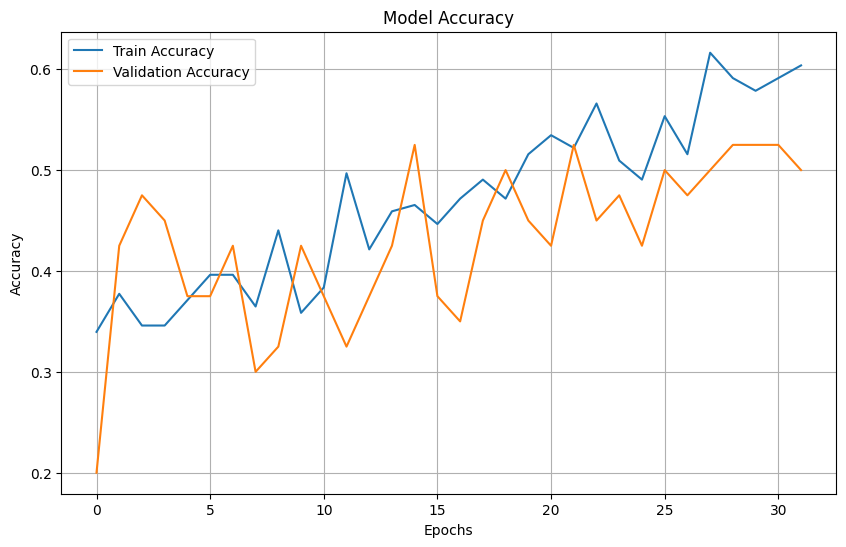

In [15]:
# Plotting test-train accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

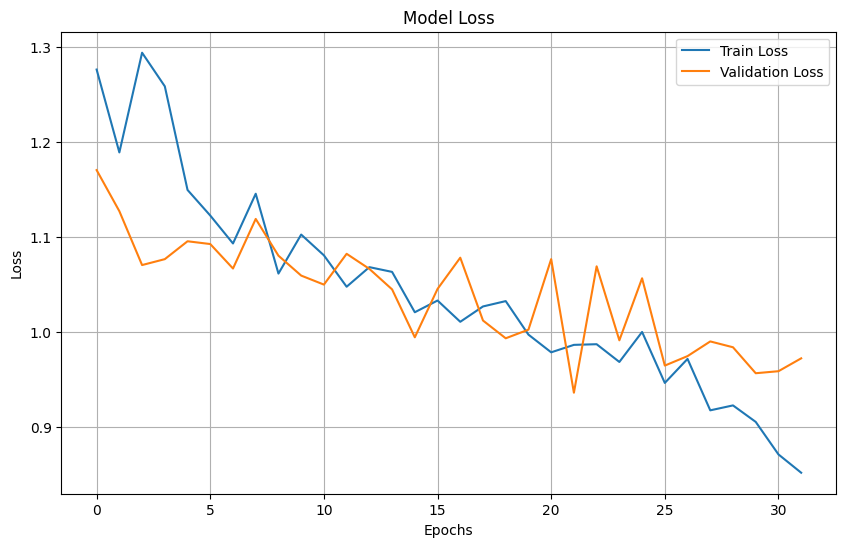

In [16]:
# Plotting loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

2/2 [==============================] - 1s 56ms/step


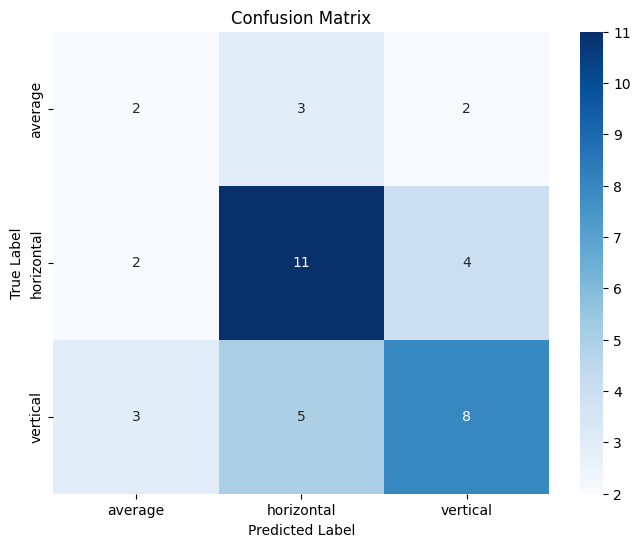

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
predictions = model.predict(test_X)
y_pred = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
# Predict classes for the test dataset
predictions = model.predict(test_X)

# Get the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Map the indices to class labels
predicted_classes = [categories[idx] for idx in predicted_class_indices]

2/2 [==============================] - 0s 55ms/step


In [19]:
# Get the actual class labels
actual_classes = [categories[idx] for idx in test_y]

# Print predicted vs actual classes for test dataset
print("Predicted vs Actual classes for the test dataset:")
for pred_class, actual_class in zip(predicted_classes, actual_classes):
    print(f"{pred_class}, {actual_class}")


Predicted vs Actual classes for the test dataset:
horizontal, horizontal
horizontal, average
horizontal, horizontal
horizontal, vertical
horizontal, horizontal
horizontal, vertical
vertical, horizontal
horizontal, horizontal
vertical, horizontal
vertical, vertical
average, vertical
vertical, vertical
horizontal, horizontal
horizontal, average
average, horizontal
horizontal, horizontal
average, average
average, horizontal
horizontal, horizontal
horizontal, vertical
horizontal, average
vertical, vertical
horizontal, horizontal
average, vertical
horizontal, horizontal
vertical, vertical
vertical, vertical
vertical, average
average, average
vertical, vertical
horizontal, vertical
vertical, average
horizontal, vertical
vertical, vertical
vertical, horizontal
horizontal, horizontal
vertical, vertical
average, vertical
horizontal, horizontal
vertical, horizontal


In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_class(model, img_path, categories):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = categories[predicted_class_index]

    return predicted_class

# Example usage:
img_path = '/content/drive/MyDrive/dental/average/Picture1.jpg'
predicted_class = predict_class(model, img_path, categories)
print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 882ms/step
Predicted class: average
